<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Imports" data-toc-modified-id="Data-Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Imports</a></span></li><li><span><a href="#Data-Examination" data-toc-modified-id="Data-Examination-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Examination</a></span><ul class="toc-item"><li><span><a href="#Photos" data-toc-modified-id="Photos-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Photos</a></span></li><li><span><a href="#Label-distribution" data-toc-modified-id="Label-distribution-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Label distribution</a></span></li></ul></li><li><span><a href="#Network-implementation" data-toc-modified-id="Network-implementation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Network implementation</a></span></li></ul></div>

# Bird Classifier

Built using the Kaggle sourced <a href=https://www.kaggle.com/datasets/gpiosenka/100-bird-species>dataset</a> of 525 bird species.

## Data Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torchvision import datasets, transforms, models

from tqdm.notebook import tqdm

In [2]:
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

In [3]:
batch_size = 16

In [4]:
data_dir = '/media/metal_undivided/DATA/Datasets/Kaggle_525_species/'

train_dataset = datasets.ImageFolder(data_dir + 'train/', transform=transform)
val_dataset = datasets.ImageFolder(data_dir + 'valid/', transform=transform)
test_dataset = datasets.ImageFolder(data_dir + 'test/', transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [5]:
#next(iter(train_dataloader))[0]

The data is successfully imported, let's examine it.

## Data Examination

### Photos

In [6]:
pixels, labels = next(iter(train_dataloader))

Let's also get the label-species pairs for visualisation.

In [7]:
species = train_dataset.find_classes(data_dir + 'train/')
species = {label:name for name, label in species[1].items()}

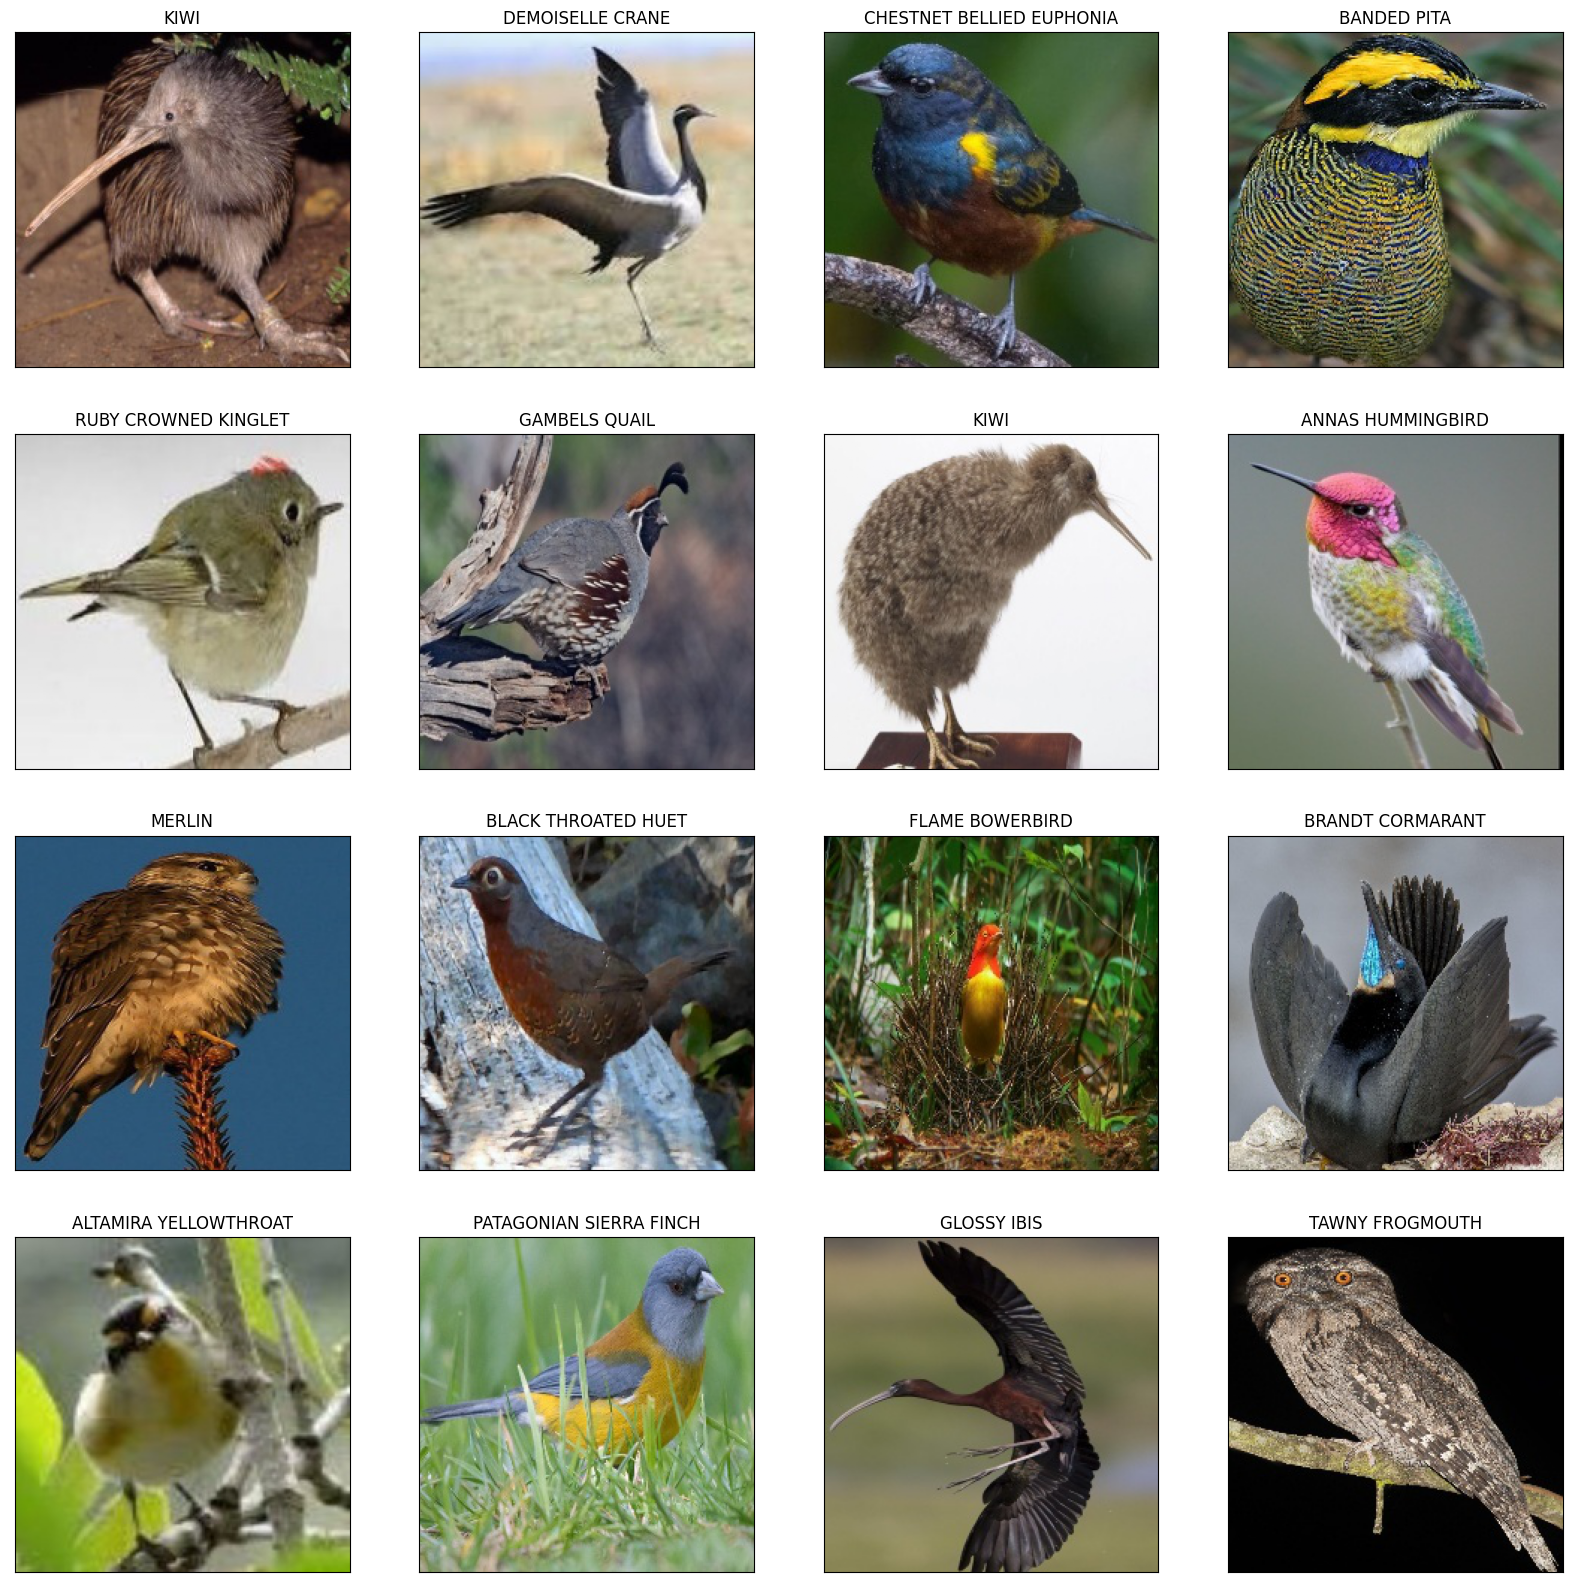

In [8]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

for i in range(16):
    axobject = axs[i // 4][i % 4]
    
    axobject.imshow(pixels[i].permute(1, 2, 0))
    axobject.set_title(species[labels.numpy()[i]])
    axobject.get_xaxis().set_visible(False)
    axobject.get_yaxis().set_visible(False)

Looks good, both the names and the images.

Before implementing the network, let's see how many photos of each bird we have.

### Label distribution

Since iterating over all the classes is fairly time consuming, this section is normally omitted and counts precalculated here are used instead.

```python
species_count = torch.zeros(525)
species_count.requires_grad = False

for counter, batch in enumerate(tqdm(train_dataloader)):
    _, labels = batch
    species_count += nn.functional.one_hot(labels, num_classes=525).sum(axis=0)    
    
```

```python
torch.save(species_count, 'species_count')
```

Loading precalculated counts

In [9]:
species_count = torch.load('species_count')

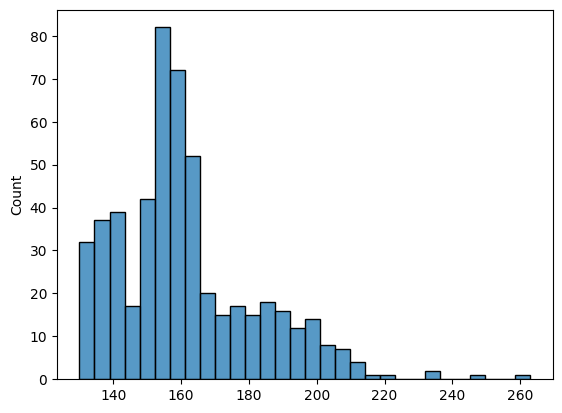

In [10]:
sns.histplot(species_count.numpy(), bins=30);

Most of the classes are fairly equally represented, save for a few outliers.

In order to improve learning, we'll use the inverse of these counts as class weights.

## Network implementation

For this task I'll be implementing a ResNet network.

In [11]:
class ResNet(nn.Module):
    
    def __init__(self, n_labels):
        super(ResNet, self).__init__()
        
        self.base = nn.Conv2d(3, 64, (7, 7), stride=2, padding=3)
        self.pool = nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1)
        
        self.block1 = self.ResNetLayer(BottleneckBlock, 64, 256, 3)
        self.downsampling1 = nn.Conv2d(256, 128, (1, 1), stride=1)
        #self.pooling1 = nn.MaxPool2d((3, 3), stride=2, padding=1)
        
        self.block2 = self.ResNetLayer(BottleneckBlock, 128, 512, 4)
        self.downsampling2 = nn.Conv2d(512, 256, (1, 1), stride=1)
        #self.pooling2 = nn.MaxPool2d((3, 3), stride=2, padding=1)
        
        self.block3 = self.ResNetLayer(BottleneckBlock, 256, 1024, 6)
        self.downsampling3 = nn.Conv2d(1024, 512, (1, 1), stride=1)
        #self.pooling3 = nn.MaxPool2d((3, 3), stride=2, padding=1)
        
        self.block4 = self.ResNetLayer(BottleneckBlock, 512, 2048, 3)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.linear = nn.Linear(2048, n_labels, bias=True)
        
    
    def forward(self, x):
        
        x = self.base(x)
        x = nn.ReLU()(x)
        x = self.pool(x)
        
        x = self.block1(x)
        x = self.downsampling1(x)
        #x = self.pooling1(x)
        
        x = self.block2(x)
        x = self.downsampling2(x)
        #x = self.pooling2(x)
        
        x = self.block3(x)
        x = self.downsampling3(x)
        #x = self.pooling3(x)
        
        x = self.block4(x)
        
        x = self.avgpool(x)
        x = nn.Flatten()(x)
        x = self.linear(x)
        #x = nn.Softmax(dim=1)(x)
        
        return x
    
    
    def ResNetLayer(self, block, input_channels, output_channels, repetitions):
        
        layer = nn.Sequential()
        
        for i in range(repetitions - 1):
            layer.append(block(input_channels, output_channels))
            ## Downsampling back to the input dimensions
            layer.append(nn.Conv2d(output_channels, input_channels, (1, 1), stride=1))
        
        ## Last block without downsampling
        layer.append(block(input_channels, output_channels, stride=2))
        
        return layer

In [12]:
class BottleneckBlock(nn.Module):
    
    def __init__(self, input_channels, output_channels, stride=1):
        super(BottleneckBlock, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        
        self.layer1 = nn.Conv2d(input_channels, input_channels, (1, 1), stride=1)
        self.layer2 = nn.Conv2d(input_channels, input_channels, (3, 3), stride=stride, padding=1)
        self.layer3 = nn.Conv2d(input_channels, output_channels, (1, 1), stride=1)
        self.residual = nn.Conv2d(input_channels, output_channels, (1, 1), stride=stride)
        
        
    def forward(self, x):
        
        x_init = x
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.layer3(x)
        x += self.residual(x_init)
        x = nn.ReLU()(x)
        
        return x
    

In [13]:
def fit_batch(model, features, target, optimizer, loss_fn):
    
    optimizer.zero_grad(set_to_none=True)
    
    predictions = model(features)
    
    loss = loss_fn(predictions, target)
    loss.backward()
    
    optimizer.step()
    
    return loss

In [ ]:
torch.cuda.is_available()

In [ ]:
builtin = models.resnet50()

In [ ]:
model = ResNet(n_labels=525)

In [ ]:
model

In [ ]:
builtin

In [ ]:
model = ResNet(n_labels=525)
#model = models.resnet50()

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters())

loss_fn = nn.CrossEntropyLoss()#weight=(species_count.mean() / species_count) ** 2)


In [ ]:
model.train(True)

for epoch in range(5):

    ## training
    total_loss = 0
    for counter, batch in enumerate(tqdm(train_dataloader)):

        features, target = batch

        total_loss += fit_batch(model, features, target, optimizer, loss_fn).item() 

        if counter % 100 == 99:
            last_loss = total_loss / len(batch) / 100
            print('Batch {1} loss: {0:.8f}'.format(last_loss, counter + 1))
            total_loss = 0
            
    ## validation
    with torch.no_grad():
        correct_labels = 0
        
        for counter, batch in enumerate(val_dataloader):
            
            pixels, labels = batch
            
            ## all predictions
            predictions = torch.max(model(pixels), dim=1)[1]
            ## number of correct predictions
            predictions = torch.sum(predictions == labels[0])
            correct_labels += predictions
        
        print('Epoch {0} validation accuracy {1:.6%}'.format(epoch + 1, correct_labels / (counter * batch_size)))